In [20]:
import os
import imghdr
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [21]:
data_dir = "/Users/csantana/Dev/TCC/datasets/fruit_type_classifier/dataset_pca_50/train"

In [22]:
img_exts = ["jpeg", "jpg", "png"]

In [23]:
for img_class in os.listdir(data_dir):
    for img in os.listdir(os.path.join(data_dir, img_class)):
        img_path = os.path.join(data_dir, img_class, img)
        try:
            cv.imread(img_path)
            _type = imghdr.what(img_path)
            if _type not in img_exts:
                print("img extension not in img_exts {}".format(img_path))
                os.remove(img_path)
        except Exception as e:
            print("issue with image {}".format(img_path))

In [24]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 5642 files belonging to 3 classes.


In [25]:
import pathlib

data_dir = pathlib.Path(data_dir)

In [26]:
image_count = len(list(data_dir.glob("*/*.jpg")))
print(image_count)

5642


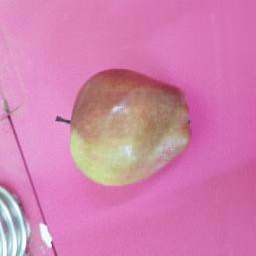

In [27]:
apples = list(data_dir.glob("apple/*"))
PIL.Image.open(str(apples[0]))

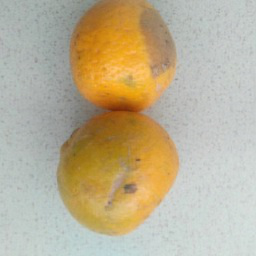

In [28]:
oranges = list(data_dir.glob("orange/*"))
PIL.Image.open(str(oranges[31]))

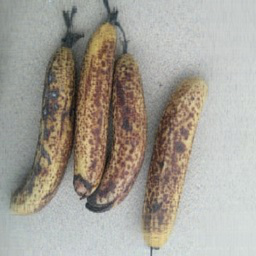

In [29]:
bananas = list(data_dir.glob("banana/*"))
PIL.Image.open(str(bananas[20]))

In [30]:
batch_size = 32
img_height = 256
img_width = 256

In [31]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 5642 files belonging to 3 classes.
Using 4514 files for training.


In [32]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 5642 files belonging to 3 classes.
Using 1128 files for validation.


In [33]:
class_names = train_ds.class_names
print(class_names)

['apple', 'banana', 'orange']


## Visualize the data


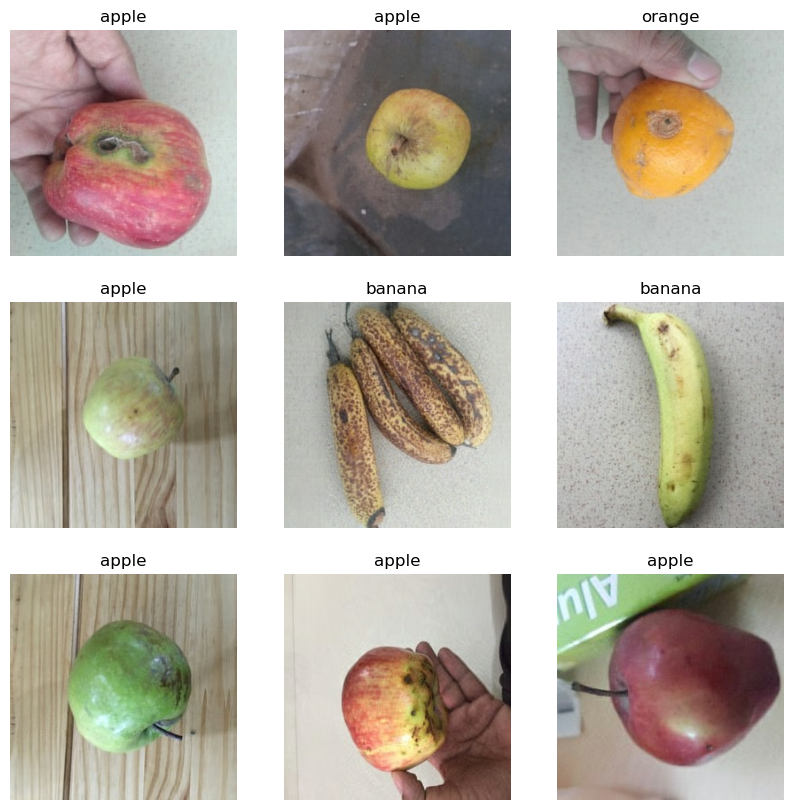

In [34]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Configure the dataset for performance

In [35]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [36]:
# normalization_layer = layers.Rescaling(1.0 / 255)

In [37]:
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

## Create the model



In [38]:
num_classes = len(class_names)

# model = Sequential(
#     [
#         layers.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),
#         layers.Conv2D(16, 3, padding="same", activation="relu"),
#         layers.MaxPooling2D(),
#         layers.Conv2D(32, 3, padding="same", activation="relu"),
#         layers.MaxPooling2D(),
#         layers.Conv2D(64, 3, padding="same", activation="relu"),
#         layers.MaxPooling2D(),
#         layers.Flatten(),
#         layers.Dense(128, activation="relu"),
#         layers.Dense(num_classes),
#     ]
# )

In [39]:
# model.compile(
#     optimizer="adam",
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=["accuracy"],
# )

In [40]:
# model.summary()

In [41]:
# epochs = 10
# history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

In [42]:
# # print(history.history)
#
# acc = history.history["accuracy"]
# val_acc = history.history["val_accuracy"]
#
# loss = history.history["loss"]
# val_loss = history.history["val_loss"]
#
# epochs_range = range(epochs)
#
# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label="Training Accuracy")
# plt.plot(epochs_range, val_acc, label="Validation Accuracy")
# plt.legend(loc="lower right")
# plt.title("Training and Validation Accuracy")
#
# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label="Training Loss")
# plt.plot(epochs_range, val_loss, label="Validation Loss")
# plt.legend(loc="upper right")
# plt.title("Training and Validation Loss")
# plt.show()

## Resolving Overfit

### Data augmentation

In [43]:
# data_augmentation = keras.Sequential(
#     [
#         layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
#         layers.RandomRotation(0.1),
#         layers.RandomZoom(0.1),
#     ]
# )

In [44]:
# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
#     for i in range(9):
#         augmented_images = data_augmentation(images)
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(augmented_images[0].numpy().astype("uint8"))
#         plt.axis("off")

### Dropout

In [52]:
model = Sequential(
    [
        # data_augmentation,
        # layers.Rescaling(1.0 / 255),
        layers.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, name="outputs"),
    ]
)

In [53]:
# model.compile(
#     optimizer="adam",
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=["accuracy"],
# )

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 128, 128, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)       

In [55]:
epochs = 3
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/3
142/142 [==============================] - 77s 536ms/step - loss: 0.5766 - accuracy: 0.7838 - val_loss: 0.1878 - val_accuracy: 0.9371
Epoch 2/3
142/142 [==============================] - 80s 566ms/step - loss: 0.1365 - accuracy: 0.9557 - val_loss: 0.1000 - val_accuracy: 0.9716
Epoch 3/3
142/142 [==============================] - 77s 542ms/step - loss: 0.0799 - accuracy: 0.9752 - val_loss: 0.1033 - val_accuracy: 0.9734


## Visualize Training Results

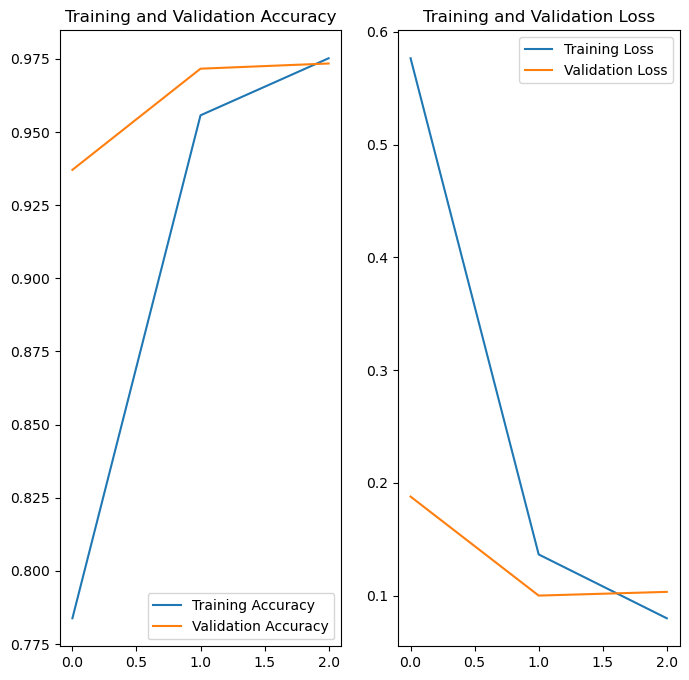

In [56]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [57]:
# from tensorflow.keras.metrics import Accuracy, Precision, Recall

# pre = Precision()
# re = Recall()
# acc = Accuracy()

# test = keras.utils.image_dataset_from_directory("rotten_fruits/train/test_/")

# for batch in test.as_numpy_iterator():
    # X, y = batch
    # yhat = model.predict(X)
    # pre.update_state(y, yhat)
    # re.update_state(y, yhat)
    # acc.update_state(y, yhat)

# print(f"Precision: {pre.result().numpy()}")
# print(f"Recall: {re.result().numpy()}")
# print(f"Accuracy: {acc.result().numpy()}")

### Test

In [62]:
def predict_image_from_path(img_path):
    img = tf.keras.utils.load_img(
        img_path, target_size=(img_height, img_width))

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array, verbose=False)
    score = tf.nn.softmax(predictions[0])

    res = class_names[np.argmax(score)]
    percentage = 100 * np.max(score)
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(res, percentage)
    )

    return res, percentage

In [59]:
img_path = "/home/ec2-user/dataset/test/banana/"
predict_image_from_path(img_path)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ec2-user/dataset/test/banana/'

#### One directory of images (change expected class)

In [63]:
test_dir = "/Users/csantana/Dev/TCC/datasets/fruit_type_classifier/dataset_pca_50/test/apple"

total_size = len(os.listdir(test_dir))
total_right = 0

expected_class = "apple"

for img in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img)

    res, percentage = predict_image_from_path(img_path)

    if res == expected_class:
        total_right += 1

print(
    f"Result overall: got { total_right }/{ total_size } right, which means { total_right * 100 / total_size }%"
)

This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 99.71 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 97.79 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 84.59 percent confidence.
This image most likely belongs to apple with a 99.99 percent confidence.
This image most likely belongs to apple with a 99.97 percent confidence.
This image most likely belongs to apple wit

#### Directories with images of three classes

In [64]:
test_dir = "/Users/csantana/Dev/TCC/datasets/fruit_type_classifier/dataset_pca_50/test"

apples_right = 0
oranges_right = 0
bananas_right = 0

for img_class in os.listdir(test_dir):
    for img in os.listdir(os.path.join(test_dir, img_class)):
        img_path = os.path.join(test_dir, img_class, img)

        res, percentage = predict_image_from_path(img_path)

        if img_class == "apple" and res == "apple":
            apples_right += 1
        elif img_class == "banana" and res == "banana":
            bananas_right += 1
        elif img_class == "orange" and res == "orange":
            oranges_right += 1
    print()

apples_size = len(os.listdir(os.path.join(test_dir, "apple")))
bananas_size = len(os.listdir(os.path.join(test_dir, "banana")))
oranges_size = len(os.listdir(os.path.join(test_dir, "orange")))
total_size = apples_size + bananas_size + oranges_size
total_right = apples_right + bananas_right + oranges_right

print(
    f"Result apples: got { apples_right }/{ apples_size } right, which means { apples_right * 100 / apples_size }%"
)
print(
    f"Result bananas: got { bananas_right }/{ bananas_size } right, which means { bananas_right * 100 / bananas_size }%"
)
print(
    f"Result oranges: got { oranges_right }/{ oranges_size } right, which means { oranges_right * 100 / oranges_size }%"
)
print()
print(
    f"Result overall: got { total_right }/{ total_size } right, which means { total_right * 100 / total_size }%"
)

This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 99.71 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 97.79 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 84.59 percent confidence.
This image most likely belongs to apple with a 99.99 percent confidence.
This image most likely belongs to apple with a 99.97 percent confidence.
This image most likely belongs to apple wit

## Save Model


In [66]:
model.save('models/fruit_type_classifier_v2.h5')

In [38]:
import boto3

obj = boto3.client("s3")
# Uploading a png file to S3 in 
# 'mygfgbucket' from local folder
obj.upload_file(
    Filename="models/fruitclassifier.h5",
    Bucket="fruit-lens-dream-team-user-data",
    Key="fruitclassifier.h5"
)

In [ ]:
# from tensorflow.keras.metrics import Accuracy, Precision, Recall, SparseCategoricalAccuracy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# pre = Precision()
# re = Recall()
acc = SparseCategoricalAccuracy()

test = keras.utils.image_dataset_from_directory("data/rotten_fruits/test/test_/", image_size=(img_height, img_width))

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    # pre.update_state(y, yhat)
    # re.update_state(y, yhat)
    acc.update_state(y, yhat)

# print(f"Precision: {pre.result().numpy()}")
# print(f"Recall: {re.result().numpy()}")
print(f"Accuracy: {acc.result().numpy()}")

### Testing with apple photos taken by me

In [ ]:
# new_model = tf.keras.models.load_model('models/fruitclassifier.h5')
# new_model.summary()

test_dir = "data/macas_real"

total_size = len(os.listdir(test_dir))
total_right = 0

expected_class = "apple"

for img in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img)

    img = tf.keras.utils.load_img(
        img_path, target_size=(img_height, img_width))

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array, verbose=False)
    score = tf.nn.softmax(predictions[0])

    res = class_names[np.argmax(score)]
    percentage = 100 * np.max(score)
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(res, percentage)
    )

    if res == expected_class:
        total_right += 1

print(
    f"Result overall: got { total_right }/{ total_size } right, which means { round( total_right * 100 / total_size, 2) }%"
)
